In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%tensorflow_version 1.x
import tensorflow 
print(tensorflow.__version__)

# !pip install q keras==2.2.0
import keras
print(keras.__version__)
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers import Dropout,Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
import pickle
import pandas as pd


TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data= pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data= pickle.load(f)

print(type(train_data))

X_train,y_train= train_data['features'],train_data['labels']
X_val,y_val= val_data['features'],val_data['labels']
X_test,y_test= test_data['features'],test_data['labels']

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0]==y_train.shape[0]),"the number of images is not equal to the number of label"
assert(X_val.shape[0]==y_val.shape[0]),"the number of images is not equal to the number of label"
assert(X_test.shape[0]==y_test.shape[0]),"the number of images is not equal to the number of label"

assert(X_train.shape[1:]==(32,32,3)),"the dimensions of the images is note 32 x 32 x3"
assert(X_val.shape[1:]==(32,32,3)),"the dimensions of the images is note 32 x 32 x3"
assert(X_test.shape[1:]==(32,32,3)),"the dimensions of the images is note 32 x 32 x3"

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

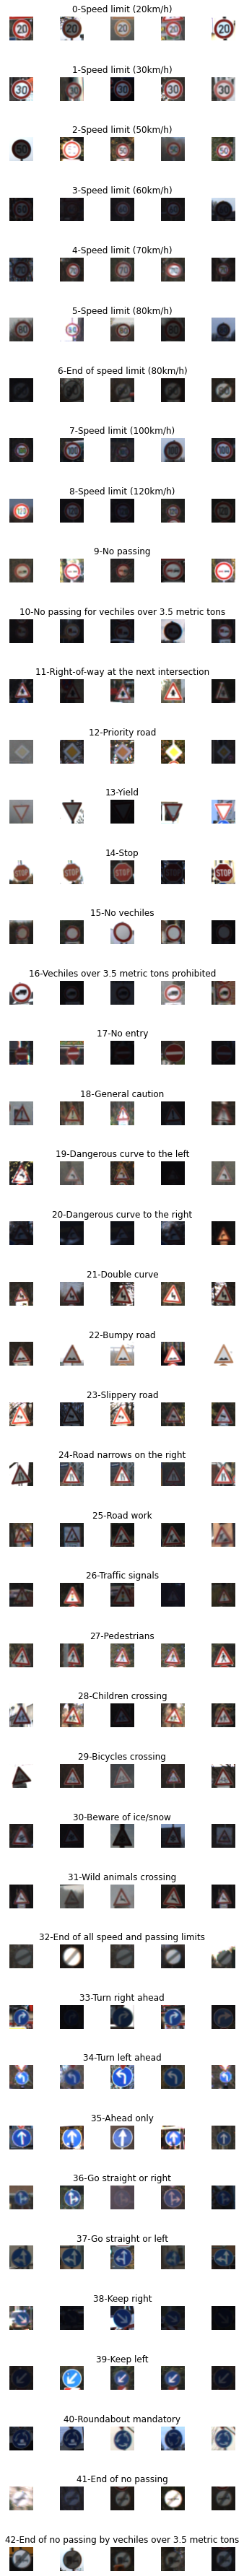

In [ ]:
import random
num_of_samples = []
     
cols = 5
num_classes = 43
  
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" +row["SignName"])
            num_of_samples.append(len(x_selected))

    #(index,series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


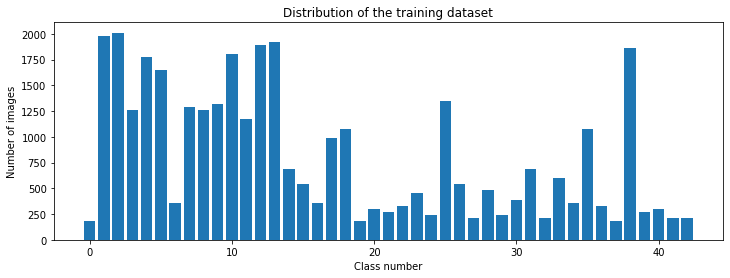

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(-0.5, 31.5, 31.5, -0.5)

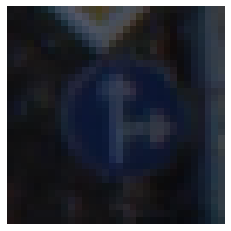

In [ ]:
import cv2
plt.imshow(X_train[1000])
plt.axis('off')
# print(X_train[1000].shape)
# print(X_train[1000])
# print(y_train[1000])

(32, 32)


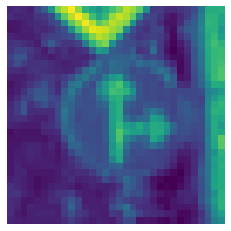

In [ ]:
#preprocessing technique
def grayscale(img):
  img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


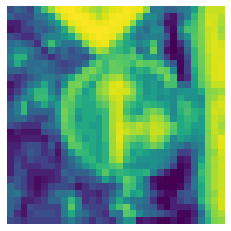

In [ ]:
#histogram equalization
def equalize(img):
  img= cv2.equalizeHist(img)   #only accept gray scale image
  return img

img= equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img =grayscale(img)
  img =equalize(img)
  img =img/255
  return img

X_train= np.array(list(map(preprocessing,X_train)))
X_val= np.array(list(map(preprocessing,X_val)))
X_test= np.array(list(map(preprocessing,X_test)))

(34799, 32, 32)


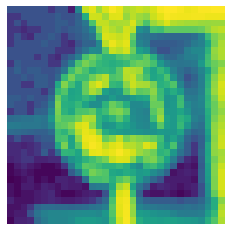

In [ ]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val= X_val.reshape(4410,32,32,1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)

datagen.fit(X_train)

val_datagen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
val_datagen.fit(X_val)

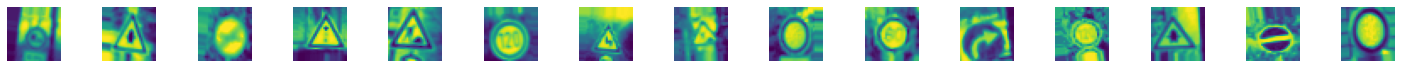

In [ ]:
batches = datagen.flow(X_train,y_train, batch_size=20)
X_batch , y_batch = next(batches)

fig,axs =plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis("off")

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
y_train= to_categorical(y_train,43)
y_val= to_categorical(y_val,43)
y_test= to_categorical(y_test,43)

print(y_train.shape)

(34799, 43)


In [ ]:
#TRAIN OUR NEURAL NETWORK using LeNet System
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5),input_shape=(32,32,1),activation= 'relu'))
  model.add(Conv2D(60, (5,5),activation= 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))

  #compile model
  model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
  return model
  


In [ ]:
model= modified_model()
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,validation_data=val_datagen.flow(X_val,y_val), shuffle = 1)
# history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch=2000, epochs=10 ,validation_data=(X_val,y_val),shuffle=1)
# history = model.fit(X_train,y_train, epochs=10, batch_size=400, validation_data=(X_val,y_val), verbose=1 ,shuffle='True')

Epoch 1/10
2000/2000 [==============================] - 40s 20ms/step - loss: 0.9661 - acc: 0.7169 - val_loss: 0.2936 - val_acc: 0.9118
Epoch 2/10
2000/2000 [==============================] - 33s 17ms/step - loss: 0.2527 - acc: 0.9218 - val_loss: 0.1768 - val_acc: 0.9524
Epoch 3/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.1679 - acc: 0.9484 - val_loss: 0.1615 - val_acc: 0.9580
Epoch 4/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1324 - acc: 0.9591 - val_loss: 0.1237 - val_acc: 0.9621
Epoch 5/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.1093 - acc: 0.9659 - val_loss: 0.1493 - val_acc: 0.9676
Epoch 6/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0972 - acc: 0.9703 - val_loss: 0.1088 - val_acc: 0.9710
Epoch 7/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0885 - acc: 0.9730 - val_loss: 0.0816 - val_acc: 0.9780
Epoch 8/10
2000/2000 [==========================

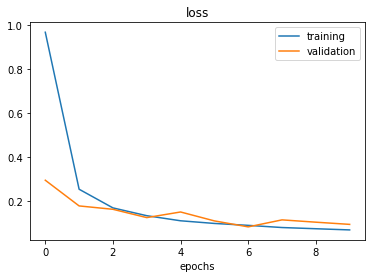

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.xlabel("epochs")
plt.legend(["training","validation"])

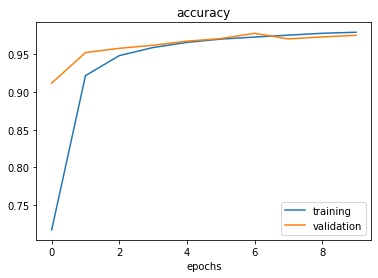

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("accuracy")
plt.xlabel("epochs")
plt.legend(["training","validation"])

In [ ]:
score = model.evaluate(X_test,y_test,verbose=0)
print("Test score:",score[0])
print("Accuracy test:",score[1])

Test score: 0.10237410886056304
Accuracy test: 0.9739509


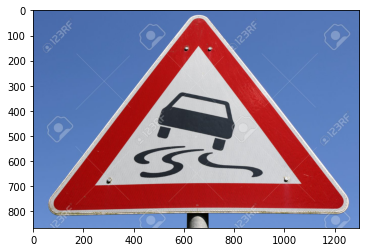

In [ ]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


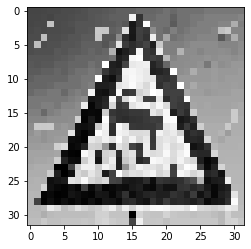

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img=img.reshape(1,32,32,1)

In [ ]:
print("predicted sign:" + str(model.predict_classes(img)))

predicted sign:[23]
